In [2]:
# import pandas as pd
import csv
import numpy as np
import os
from os.path import join as pjoin
from glob import iglob

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
#!/usr/bin/env python
from __future__ import division

import argparse
import glob
import os
import random
import signal
import time

import torch

import distributed
from models import data_loader, model_builder
from models.data_loader import load_dataset
from models.model_builder import ExtSummarizer
from models.trainer_ext import build_trainer
from others.logging import logger, init_logger

model_flags = ['hidden_size', 'ff_size', 'heads', 'inter_layers', 'encoder', 'ff_actv', 'use_interval', 'rnn_size']


In [4]:
root_path = '/data/ksb/'
bert_root_path = pjoin(root_path, 'BertSum/PreSumm')
bert_model_dir = pjoin(bert_root_path, 'models')

data_dir = pjoin(root_path, 'cnn-dailymail/finished_files')
three_data_dir = pjoin(root_path, 'three-mat')
three_data_test = pjoin(three_data_dir, 'test')


#### Loss function 비교  

*Trained Model parameter 필요*


In [5]:
def get_cos_similarity(inputs, sents):
    tfidf_vectorizer = TfidfVectorizer()

    cos_similarity_list = []
    for input_, sent_ in zip(inputs, sents):
        try:
            tfidf_matrix = tfidf_vectorizer.fit_transform([input_, sent_])

            similarity = cosine_similarity(tfidf_matrix[0] , tfidf_matrix[1])[0][0]
        except ValueError:
            similarity = 0.0
            
        cos_similarity_list.append(similarity)

    return cos_similarity_list

### Origin candidate set

In [7]:
import copy
import jsonlines

In [8]:
new_data_path = pjoin(three_data_dir,'test.jsonl')

In [9]:
def get_article_list(path):
    
    article_list = []
    
    with jsonlines.open(path) as reader:
        for data in reader:
            
            article = data['article']
            candidates = data['candidates']
            abstract = data['abstract']
            
            new_cand_ph_re = data['phase-rewrite ']
            new_cand_se_re = data['sentence_rewrite']
            new_cand_ph_mr = data['phase-masking-rewriting']

            dataset = (article, candidates, abstract, new_cand_ph_re, new_cand_se_re, new_cand_ph_mr)
            article_list.append(dataset)
        
    return article_list
    

In [10]:
article_list = get_article_list(new_data_path)

In [11]:
article_list[0][3]

[["club tijuana star juan arango conjured memories l su in his team 's 4-3 defeat by monterrey in the mexican league - but it was not through prodigious scoring .",
  'he was not booked. by the referee but could face a heavy retrospective ban .',
  'juan arango ( left) bites the shoulder of opponent jesus zavela in a moment of madness'],
 ["juan arango bites jesus zavela in a moment of madness in club tijuana 's 4-3 defeat by monterrey in the mexican league .",
  'the venezuelan his teeth into the shoulder of the opponent as his temper flared in the defeat .',
  'he was not booked. by the referee but could face a heavy retrospective ban .',
  'arango had earlier curled in a magnificent free kick for his team to bring them level after falling 2-0 down .'],
 ["juan arango bites jesus zavela in club tijuana 's 4-3 defeat by monterrey in the mexican league .",
  'the venezuelan his teeth into the shoulder of jesus zavala in a moment of madness .',
  'he was not booked. by the referee but c

In [12]:
## Phase Rewrite
origin_doc_sims = []
origin_ref_rouges = []

## Phase Rewrite
ph_re_doc_sims = []
ph_re_ref_rouges = []

## Sentence Rewrite
se_re_doc_sims = []
se_re_ref_rouges = []

## Phase masking & Rewriting
ph_mr_doc_sims = []
ph_mr_ref_rouges = []

In [13]:
from rouge import Rouge
rouge = Rouge()

In [14]:
for article_set in article_list:
    article = article_set[0]
    abstract = article_set[2]
    
    candidates = article_set[1]
    new_cand_ph_re = article_set[3]
    new_cand_se_re = article_set[4]
    new_cand_ph_mr = article_set[5]
    
    origin_doc_sim_3 = [np.mean(get_cos_similarity(article, cand[0])) for cand in candidates]
    ph_re_doc_sim_3 = [np.mean(get_cos_similarity(article, cand)) for cand in new_cand_ph_re]
    se_re_doc_sim_3 = [np.mean(get_cos_similarity(article, cand)) for cand in new_cand_se_re]
    ph_mr_doc_sim_3 = [np.mean(get_cos_similarity(article, cand)) for cand in new_cand_ph_mr]
    
    origin_doc_sims.append(np.mean(origin_doc_sim_3))
    ph_re_doc_sims.append(np.mean(ph_re_doc_sim_3))
    se_re_doc_sims.append(np.mean(se_re_doc_sim_3))
    ph_mr_doc_sims.append(np.mean(ph_mr_doc_sim_3))
    
    origin_rouge_3 = [rouge.get_scores('\n'.join(article), '\n'.join(cand[0]))[0]['rouge-l']['f'] for cand in candidates]
    ph_re_rouge_3 = [rouge.get_scores('\n'.join(article), '\n'.join(cand))[0]['rouge-l']['f'] for cand in new_cand_ph_re]
    se_re_rouge_3 = [rouge.get_scores('\n'.join(article), '\n'.join(cand))[0]['rouge-l']['f'] for cand in new_cand_se_re]
    ph_mr_rouge_3 = [rouge.get_scores('\n'.join(article), '\n'.join(cand))[0]['rouge-l']['f'] for cand in new_cand_ph_mr]
    
    origin_ref_rouges.append(np.mean(origin_rouge_3))
    ph_re_ref_rouges.append(np.mean(ph_re_rouge_3))
    se_re_ref_rouges.append(np.mean(se_re_rouge_3))
    ph_mr_ref_rouges.append(np.mean(ph_mr_rouge_3))
    
    print("cosine similarity\n")
    print("Origin : {}".format(origin_doc_sim_3))
    print("Rewrite Phase : {}".format(ph_re_doc_sim_3))
    print("Rewrite Sentence : {}".format(se_re_doc_sim_3))
    print("Phase Masking & Generate : {}\n\n".format(ph_mr_doc_sim_3))

    print("ROUGE score\n")
    print("Origin : {}".format(origin_rouge_3))
    print("Rewrite Phase : {}".format(ph_re_rouge_3))
    print("Rewrite Sentence : {}".format(se_re_rouge_3))
    print("Phase Masking & Generate : {}".format(ph_mr_rouge_3))

cosine similarity

Origin : [0.3749457697160617, 0.5933693329798111, 0.7106895463781727]
Rewrite Phase : [0.3410189452289128, 0.5778945821911492, 0.6901636102492192]
Rewrite Sentence : [0.29423034689641164, 0.5858516922365871, 0.7389894694008966]
Phase Masking & Generate : [0.3439162755501986, 0.5858516922365871, 0.7389894694008966]


ROUGE score

Origin : [0.5714285673469389, 0.6292134787526829, 0.4528301849768601]
Rewrite Phase : [0.5269461037398258, 0.6136363592975207, 0.4331210155057001]
Rewrite Sentence : [0.4779874176812626, 0.6292134787526829, 0.4331210155057001]
Phase Masking & Generate : [0.4499999962500001, 0.6292134787526829, 0.4331210155057001]
cosine similarity

Origin : [0.13298754647459657, 0.4245319309217488, 0.1564359070137863]
Rewrite Phase : [0.13298754647459657, 0.40981595267472964, 0.15932745021655373]
Rewrite Sentence : [0.1342513396538308, 0.40981595267472964, 0.15462437236942522]
Phase Masking & Generate : [0.1342513396538308, 0.40981595267472964, 0.154624372369

cosine similarity

Origin : [0.3333333333333334, 0.023961372487215717, 0.36219929935255335]
Rewrite Phase : [0.3333333333333334, 0.023961372487215717, 0.36219929935255335]
Rewrite Sentence : [0.30586993670419055, 0.023961372487215717, 0.36219929935255335]
Phase Masking & Generate : [0.30586993670419055, 0.023961372487215717, 0.36219929935255335]


ROUGE score

Origin : [0.513888885070409, 0.5442176831135175, 0.5241379271667063]
Rewrite Phase : [0.513888885070409, 0.5442176831135175, 0.5241379271667063]
Rewrite Sentence : [0.46153845777104013, 0.5241379271667063, 0.5241379271667063]
Phase Masking & Generate : [0.4335664297990122, 0.4827586168218788, 0.4827586168218788]
cosine similarity

Origin : [0.16400040782312655, 0.3950689951278242, 0.5426553881039885]
Rewrite Phase : [0.16400040782312655, 0.391511325293944, 0.5426553881039885]
Rewrite Sentence : [0.16400040782312655, 0.3950689951278242, 0.5426553881039885]
Phase Masking & Generate : [0.16400040782312655, 0.3950689951278242, 0.5426

cosine similarity

Origin : [0.12172330436593713, 0.6271008345708072, 0.1313435395907432]
Rewrite Phase : [0.12172330436593713, 0.6056557275614306, 0.1313435395907432]
Rewrite Sentence : [0.10985964470415126, 0.5965125395558978, 0.1313435395907432]
Phase Masking & Generate : [0.10985964470415126, 0.5965125395558978, 0.1313435395907432]


ROUGE score

Origin : [0.47104246744145145, 0.4591439653342216, 0.35483870645811655]
Rewrite Phase : [0.47104246744145145, 0.44531249649536137, 0.35483870645811655]
Rewrite Sentence : [0.40784313378362175, 0.43137254554832766, 0.3481781344713075]
Phase Masking & Generate : [0.393700783964288, 0.43137254554832766, 0.3306451580710198]
cosine similarity

Origin : [0.13687528037822533, 0.19116491190025106, 0.1357480209294627]
Rewrite Phase : [0.13570476078579452, 0.1897373211037038, 0.11457852905300174]
Rewrite Sentence : [0.13687528037822533, 0.19116491190025106, 0.14449789868388052]
Phase Masking & Generate : [0.13687528037822533, 0.19116491190025106, 0.

cosine similarity

Origin : [0.08712731927126392, 0.2714344113254125, 0.0923448471084356]
Rewrite Phase : [0.07927382516416194, 0.2695917009244015, 0.08671512960416691]
Rewrite Sentence : [0.0869067957726521, 0.24856652504323729, 0.09150963688277909]
Phase Masking & Generate : [0.0869067957726521, 0.24856652504323729, 0.09150963688277909]


ROUGE score

Origin : [0.33862433581142753, 0.23595505409859868, 0.30270270013382033]
Rewrite Phase : [0.32978723128847903, 0.23098591344987107, 0.2818428158914814]
Rewrite Sentence : [0.3155080186965599, 0.22033898104631497, 0.2872628700920234]
Phase Masking & Generate : [0.3048128315307844, 0.20903954601806635, 0.2717391279306475]
cosine similarity

Origin : [0.5987792364520875, 0.6054598441003823, 0.4349085438343127]
Rewrite Phase : [0.6035829594176723, 0.5894952226851039, 0.44246058221407597]
Rewrite Sentence : [0.5843284463873624, 0.5434251041448798, 0.40572734975538677]
Phase Masking & Generate : [0.5942711683991887, 0.5434251041448798, 0.4057

cosine similarity

Origin : [0.12031534887500084, 0.11500815698047853, 0.08717982602885922]
Rewrite Phase : [0.11938343851869417, 0.11500815698047853, 0.08794111745257077]
Rewrite Sentence : [0.10297480388513869, 0.11500815698047853, 0.08794111745257077]
Phase Masking & Generate : [0.10297480388513869, 0.11500815698047853, 0.08794111745257077]


ROUGE score

Origin : [0.44516128686181067, 0.3028168988387721, 0.3799999968402223]
Rewrite Phase : [0.44516128686181067, 0.3028168988387721, 0.37333333017355563]
Rewrite Sentence : [0.40645160944245584, 0.2887323917965186, 0.3678929734615944]
Phase Masking & Generate : [0.40645160944245584, 0.275618372030616, 0.3557046948927977]
cosine similarity

Origin : [0.07713150568812797, 0.06371962700335991, 0.04330625840611582]
Rewrite Phase : [0.07713150568812797, 0.06371962700335991, 0.043844410188469685]
Rewrite Sentence : [0.07713150568812797, 0.06371962700335991, 0.04330625840611582]
Phase Masking & Generate : [0.07542694890778522, 0.0637196270033

cosine similarity

Origin : [0.3668576412457716, 0.5150350782843175, 0.3538446763821689]
Rewrite Phase : [0.3648133755802206, 0.5150350782843175, 0.3538446763821689]
Rewrite Sentence : [0.3430744361812334, 0.5150350782843175, 0.3538446763821689]
Phase Masking & Generate : [0.3430744361812334, 0.5150350782843175, 0.3538446763821689]


ROUGE score

Origin : [0.5412843997218248, 0.4099999967405001, 0.5023255775428881]
Rewrite Phase : [0.5345622080647285, 0.4099999967405001, 0.5023255775428881]
Rewrite Sentence : [0.49302325196149277, 0.3999999967405001, 0.49302325196149277]
Phase Masking & Generate : [0.49302325196149277, 0.3999999967405001, 0.49302325196149277]
cosine similarity

Origin : [1.0000000000000002, 0.1690166665238526, 0.1842088683012344]
Rewrite Phase : [0.9929503017546497, 0.1690166665238526, 0.1842088683012344]
Rewrite Sentence : [0.9437894819863313, 0.1690166665238526, 0.17598943955940524]
Phase Masking & Generate : [0.9437894819863313, 0.1690166665238526, 0.175989439559405

cosine similarity

Origin : [0.12586247280867788, 0.15763896922757079, 0.27724681191817035]
Rewrite Phase : [0.1266442214671343, 0.15763896922757079, 0.27928095999321684]
Rewrite Sentence : [0.11628203412119599, 0.15763896922757079, 0.2875217509451491]
Phase Masking & Generate : [0.11628203412119599, 0.15763896922757079, 0.2875217509451491]


ROUGE score

Origin : [0.28852458769492073, 0.24422442005424308, 0.23178807712359106]
Rewrite Phase : [0.269736839676463, 0.24422442005424308, 0.23841059367988252]
Rewrite Sentence : [0.2341137101558148, 0.24422442005424308, 0.21333333107133332]
Phase Masking & Generate : [0.2341137101558148, 0.24422442005424308, 0.20805368910026575]
cosine similarity

Origin : [0.42774760891039904, 0.351185640433907, 0.4928115068626182]
Rewrite Phase : [0.42774760891039904, 0.3531331984002722, 0.4928115068626182]
Rewrite Sentence : [0.42774760891039904, 0.351185640433907, 0.4928115068626182]
Phase Masking & Generate : [0.42774760891039904, 0.351185640433907, 0.49

cosine similarity

Origin : [0.3031013752784351, 0.7174131070557311, 0.1680906189335616]
Rewrite Phase : [0.3031013752784351, 0.7174131070557311, 0.1680906189335616]
Rewrite Sentence : [0.2894662523509943, 0.7174131070557311, 0.16924908943430172]
Phase Masking & Generate : [0.2894662523509943, 0.7174131070557311, 0.16924908943430172]


ROUGE score

Origin : [0.24999999781250004, 0.2298850554366495, 0.2433460054671891]
Rewrite Phase : [0.24999999781250004, 0.2298850554366495, 0.2433460054671891]
Rewrite Sentence : [0.23908918189818132, 0.2298850554366495, 0.23664121928762896]
Phase Masking & Generate : [0.23818525298623147, 0.2298850554366495, 0.2328244253944992]
cosine similarity

Origin : [1.0, 0.43482937180693615, 0.5512566758691317]
Rewrite Phase : [0.9723173858777017, 0.4323336938533946, 0.5481370784272048]
Rewrite Sentence : [0.9338175210480576, 0.4225610586796583, 0.5297218924791381]
Phase Masking & Generate : [0.949663017817285, 0.4225610586796583, 0.5337659303400818]


ROUGE sc

cosine similarity

Origin : [0.4351965313890564, 0.22849458253365354, 0.22948167860067714]
Rewrite Phase : [0.43035607772562096, 0.22849458253365354, 0.23215896870335634]
Rewrite Sentence : [0.4023296737693131, 0.21749762385680155, 0.2233957467959866]
Phase Masking & Generate : [0.37682015829664145, 0.21749762385680155, 0.2233957467959866]


ROUGE score

Origin : [0.2773333309445689, 0.2082191760456371, 0.22888283167712292]
Rewrite Phase : [0.26273458212881573, 0.2082191760456371, 0.22343324039646892]
Rewrite Sentence : [0.26344085792765065, 0.198347105477009, 0.21428571228671056]
Phase Masking & Generate : [0.23783783562001462, 0.18784530194484295, 0.21428571228671056]
cosine similarity

Origin : [0.1315979623864143, 0.10401802913215268, 0.24351295279531987]
Rewrite Phase : [0.13009150604554165, 0.10401802913215268, 0.24351295279531987]
Rewrite Sentence : [0.13431027854099256, 0.10401802913215268, 0.2439742997667989]
Phase Masking & Generate : [0.13431027854099256, 0.10401802913215268

cosine similarity

Origin : [1.0, 0.9012266870154342, 0.851840030523151]
Rewrite Phase : [0.9664246349238642, 0.8706395341317738, 0.8059593011976603]
Rewrite Sentence : [0.8563852668918416, 0.827972083657655, 0.8019132074916642]
Phase Masking & Generate : [0.8703000804773868, 0.8418868972432, 0.8019132074916642]


ROUGE score

Origin : [0.4924924887803119, 0.46951219152903784, 0.34323432058904907]
Rewrite Phase : [0.4759036107687981, 0.4525993848112299, 0.3245033084511645]
Rewrite Sentence : [0.4376899659873801, 0.42201834505587826, 0.3122923560335979]
Phase Masking & Generate : [0.4123076887907219, 0.39628482625693723, 0.3122923560335979]
cosine similarity

Origin : [0.0734909992752411, 0.29960899216516834, 0.05343619128044471]
Rewrite Phase : [0.07662009600893945, 0.29960899216516834, 0.05343619128044471]
Rewrite Sentence : [0.07704799503013324, 0.30076149400270186, 0.04395827994431179]
Phase Masking & Generate : [0.08060933265771836, 0.30076149400270186, 0.04395827994431179]


ROUGE

cosine similarity

Origin : [0.6666666666666669, 0.4114387346089642, 0.48786323191210895]
Rewrite Phase : [0.643760031437688, 0.4114387346089642, 0.4785015122177066]
Rewrite Sentence : [0.6127374098239503, 0.4114387346089642, 0.47930980920157384]
Phase Masking & Generate : [0.6127374098239503, 0.40869157119906374, 0.47930980920157384]


ROUGE score

Origin : [0.3842794728780916, 0.48780487431918834, 0.40677965762891416]
Rewrite Phase : [0.36681222396979474, 0.48780487431918834, 0.38983050508654127]
Rewrite Sentence : [0.353982297914872, 0.47967479301837534, 0.384615381304332]
Phase Masking & Generate : [0.353982297914872, 0.45528454911593635, 0.384615381304332]
cosine similarity

Origin : [0.17137574484702345, 0.12206820056500156, 0.10905291187404306]
Rewrite Phase : [0.1654955128049029, 0.12360663950340046, 0.10905291187404306]
Rewrite Sentence : [0.17376038870548224, 0.12206820056500156, 0.10905291187404306]
Phase Masking & Generate : [0.17376038870548224, 0.12206820056500156, 0.1090

cosine similarity

Origin : [0.37605288001491216, 0.09825574091841797, 0.21787788239467792]
Rewrite Phase : [0.37605288001491216, 0.09825574091841797, 0.21733075770387425]
Rewrite Sentence : [0.3628757783720811, 0.09723098747228635, 0.21787788239467792]
Phase Masking & Generate : [0.3628757783720811, 0.09723098747228635, 0.21787788239467792]


ROUGE score

Origin : [0.2092050190472856, 0.1882845169552354, 0.20331950008505367]
Rewrite Phase : [0.2092050190472856, 0.1882845169552354, 0.20331950008505367]
Rewrite Sentence : [0.1940928252516513, 0.18410041653682535, 0.19917012249169266]
Phase Masking & Generate : [0.16525423559752947, 0.1719077549699599, 0.18333333140138888]
cosine similarity

Origin : [0.10061074290222699, 0.1475342769159404, 0.12939400923838945]
Rewrite Phase : [0.10061074290222699, 0.1475342769159404, 0.12939400923838945]
Rewrite Sentence : [0.10061074290222699, 0.14914324662651607, 0.13100297894896512]
Phase Masking & Generate : [0.10061074290222699, 0.1491432466265160

cosine similarity

Origin : [0.5869420392740544, 0.1411029016173401, 0.27120377190368833]
Rewrite Phase : [0.6035340326459122, 0.14773969896608322, 0.27622947384118995]
Rewrite Sentence : [0.5170302265908128, 0.14246045652804823, 0.27120377190368833]
Phase Masking & Generate : [0.5170302265908128, 0.14246045652804823, 0.27120377190368833]


ROUGE score

Origin : [0.2046035787259372, 0.24060150164282895, 0.23441396290445957]
Rewrite Phase : [0.1999999982, 0.23618090243971113, 0.23441396290445957]
Rewrite Sentence : [0.179948584355377, 0.21717171515725442, 0.22942643173238977]
Phase Masking & Generate : [0.1701030910581624, 0.20759493472917803, 0.22388059479950992]
cosine similarity

Origin : [0.30380710961618784, 0.22235802196827228, 0.28803612360342284]
Rewrite Phase : [0.30380710961618784, 0.22235802196827228, 0.28803612360342284]
Rewrite Sentence : [0.30380710961618784, 0.23922796968740223, 0.28803612360342284]
Phase Masking & Generate : [0.30380710961618784, 0.24502523193539236, 0.2

cosine similarity

Origin : [0.4488865209775162, 0.4283192092363069, 0.3521455169324697]
Rewrite Phase : [0.41786979919685363, 0.39702210899606366, 0.33185532150867836]
Rewrite Sentence : [0.406625379807862, 0.38489171725248533, 0.34820428021897376]
Phase Masking & Generate : [0.428890733818118, 0.4071570712627413, 0.34820428021897376]


ROUGE score

Origin : [0.164265128175261, 0.16690647329036803, 0.1455604062194763]
Rewrite Phase : [0.1611510776069148, 0.16402877544864142, 0.14264919806809348]
Rewrite Sentence : [0.14739884246738116, 0.15273775065364717, 0.12262773592302202]
Phase Masking & Generate : [0.14161849564657192, 0.14161849564657192, 0.11403508643946002]
cosine similarity

Origin : [0.3222649963486545, 0.12017492367276439, 0.15942285639532763]
Rewrite Phase : [0.31896406842316577, 0.11144804704396313, 0.1572641365832015]
Rewrite Sentence : [0.28367892596369404, 0.12089022447714781, 0.13850605088651177]
Phase Masking & Generate : [0.28367892596369404, 0.12089022447714781, 0

cosine similarity

Origin : [0.06376464241531161, 0.04829621325600333, 0.06393021500439151]
Rewrite Phase : [0.06584790957769915, 0.04829621325600333, 0.06393021500439151]
Rewrite Sentence : [0.06441261361425012, 0.04829621325600333, 0.06393021500439151]
Phase Masking & Generate : [0.06258490717027362, 0.04829621325600333, 0.06393021500439151]


ROUGE score

Origin : [0.1621621606720234, 0.13293051219868385, 0.1775147911851826]
Rewrite Phase : [0.15082956117415017, 0.1357466049147233, 0.1775147911851826]
Rewrite Sentence : [0.15939849477365597, 0.1180030243459115, 0.16913946420484466]
Phase Masking & Generate : [0.1475903600021774, 0.1180030243459115, 0.16023738705350934]
cosine similarity

Origin : [0.7569354752331248, 0.2704482122873492, 1.0]
Rewrite Phase : [0.7515587785997607, 0.24967700272483132, 0.994623303366636]
Rewrite Sentence : [0.7685958225877152, 0.24292277580811344, 0.9957117649309158]
Phase Masking & Generate : [0.7685958225877152, 0.24292277580811344, 0.9957117649309158

cosine similarity

Origin : [0.3094787812604498, 0.28259648200707393, 0.24003112166235252]
Rewrite Phase : [0.3094787812604498, 0.2836516686202545, 0.24003112166235252]
Rewrite Sentence : [0.3174416229611686, 0.26088252763011943, 0.23802214388232387]
Phase Masking & Generate : [0.3174416229611686, 0.26088252763011943, 0.23802214388232387]


ROUGE score

Origin : [0.2269938630183673, 0.289940825923287, 0.28985506974433944]
Rewrite Phase : [0.2269938630183673, 0.2840236661599734, 0.28985506974433944]
Rewrite Sentence : [0.19195046251262837, 0.2559523785460956, 0.2748537985504942]
Phase Masking & Generate : [0.19195046251262837, 0.2559523785460956, 0.2748537985504942]
cosine similarity

Origin : [0.11707526836143568, 0.09575703155831586, 0.08857253401341696]
Rewrite Phase : [0.11058103444652187, 0.10160696650434495, 0.10021084475267249]
Rewrite Sentence : [0.0960606253937508, 0.06774805059212366, 0.08686445826929252]
Phase Masking & Generate : [0.10652513036934935, 0.06774805059212366, 0.

cosine similarity

Origin : [0.9999999999999997, 0.309254928289419, 0.5871382113219588]
Rewrite Phase : [0.9999999999999997, 0.309254928289419, 0.5871382113219588]
Rewrite Sentence : [0.9520712907223504, 0.3151487070940489, 0.5881875634303568]
Phase Masking & Generate : [0.9520712907223504, 0.3151487070940489, 0.5881875634303568]


ROUGE score

Origin : [0.25950782771927194, 0.29759299527869426, 0.2437923229156837]
Rewrite Phase : [0.25950782771927194, 0.29759299527869426, 0.2437923229156837]
Rewrite Sentence : [0.24608500892732565, 0.293859646615978, 0.23927765022945338]
Phase Masking & Generate : [0.22869954934012351, 0.293859646615978, 0.23927765022945338]
cosine similarity

Origin : [0.17695664563183358, 0.20248494593938432, 0.1715048403026386]
Rewrite Phase : [0.18105599183560783, 0.20248494593938432, 0.17432192209966957]
Rewrite Sentence : [0.17095992870213206, 0.20248494593938432, 0.17508383225944235]
Phase Masking & Generate : [0.17095992870213206, 0.20248494593938432, 0.175083

cosine similarity

Origin : [1.0000000000000007, 0.9184507481160952, 1.0000000000000007]
Rewrite Phase : [1.0000000000000007, 0.9184507481160952, 1.0000000000000007]
Rewrite Sentence : [0.9345032366473051, 0.902286817792208, 0.9345032366473051]
Phase Masking & Generate : [0.9345032366473051, 0.902286817792208, 0.9345032366473051]


ROUGE score

Origin : [0.5465116239352353, 0.5088757357935646, 0.5465116239352353]
Rewrite Phase : [0.5465116239352353, 0.5088757357935646, 0.5465116239352353]
Rewrite Sentence : [0.5119047580959468, 0.49999999619118485, 0.5119047580959468]
Phase Masking & Generate : [0.4790419124027394, 0.49999999619118485, 0.4790419124027394]
cosine similarity

Origin : [0.1701044113446966, 0.1450104188992515, 0.13684214765819222]
Rewrite Phase : [0.1701044113446966, 0.1450104188992515, 0.13684214765819222]
Rewrite Sentence : [0.1701044113446966, 0.1450104188992515, 0.13684214765819222]
Phase Masking & Generate : [0.1701044113446966, 0.1450104188992515, 0.13684214765819222

cosine similarity

Origin : [0.09390986705750803, 0.08312842530686018, 0.4019567836163505]
Rewrite Phase : [0.09342990634852605, 0.08312842530686018, 0.40306099612810087]
Rewrite Sentence : [0.09408590148754326, 0.08312842530686018, 0.4037721014718403]
Phase Masking & Generate : [0.09408590148754326, 0.08312842530686018, 0.4037721014718403]


ROUGE score

Origin : [0.45599999647968004, 0.3644067766809107, 0.42448979257442737]
Rewrite Phase : [0.45599999647968004, 0.3644067766809107, 0.41152263047638404]
Rewrite Sentence : [0.4417670647866971, 0.3644067766809107, 0.40495867445632133]
Phase Masking & Generate : [0.42741935138690174, 0.3644067766809107, 0.3900414905859059]
cosine similarity

Origin : [0.11798829040827424, 0.04221981795455643, 0.3263798329683429]
Rewrite Phase : [0.11798829040827424, 0.04221981795455643, 0.3263798329683429]
Rewrite Sentence : [0.08411140047789872, 0.04221981795455643, 0.3263798329683429]
Phase Masking & Generate : [0.08411140047789872, 0.04221981795455643,

cosine similarity

Origin : [0.09408374164228947, 0.2501460882038033, 0.6824819975074503]
Rewrite Phase : [0.09408374164228947, 0.23891989315063356, 0.6824819975074503]
Rewrite Sentence : [0.09408374164228947, 0.26904496484310364, 0.6824819975074503]
Phase Masking & Generate : [0.09408374164228947, 0.2621248910782355, 0.6824819975074503]


ROUGE score

Origin : [0.33684210246204993, 0.31466666401507554, 0.33245382308560933]
Rewrite Phase : [0.33684210246204993, 0.3093333306817423, 0.33245382308560933]
Rewrite Sentence : [0.33684210246204993, 0.3089005207017352, 0.33245382308560933]
Phase Masking & Generate : [0.33684210246204993, 0.25531914625396107, 0.33245382308560933]
cosine similarity

Origin : [1.0000000000000004, 0.18989643043220383, 0.1402696995707244]
Rewrite Phase : [0.9658578825082084, 0.18989643043220383, 0.1402696995707244]
Rewrite Sentence : [0.8897715256788965, 0.18989643043220383, 0.1402696995707244]
Phase Masking & Generate : [0.8897715256788965, 0.18989643043220383, 0.

cosine similarity

Origin : [0.06601549319943158, 0.08941561106730217, 0.049049105663897904]
Rewrite Phase : [0.06601549319943158, 0.08941561106730217, 0.0497858973316667]
Rewrite Sentence : [0.06758382692811038, 0.09063681396591589, 0.049049105663897904]
Phase Masking & Generate : [0.06758382692811038, 0.09063681396591589, 0.049049105663897904]


ROUGE score

Origin : [0.28954423344867, 0.26086956290893787, 0.22527472310786745]
Rewrite Phase : [0.28954423344867, 0.26086956290893787, 0.22038567280073465]
Rewrite Sentence : [0.23013698409848005, 0.2561307879170534, 0.21546961116617322]
Phase Masking & Generate : [0.21857923273418137, 0.2561307879170534, 0.2099447492877202]
cosine similarity

Origin : [0.16566800494757908, 0.14248750354663486, 0.17093245803305146]
Rewrite Phase : [0.16566800494757908, 0.1430235063094255, 0.17146846079584208]
Rewrite Sentence : [0.16566800494757908, 0.1442229755108455, 0.17266792999726208]
Phase Masking & Generate : [0.16566800494757908, 0.144222975510845

cosine similarity

Origin : [0.42720815482688695, 0.5513734032342985, 0.6014194214984457]
Rewrite Phase : [0.4151421856465811, 0.5455882708151841, 0.5948971537994746]
Rewrite Sentence : [0.3940760021012451, 0.5242496110525071, 0.5785588643515408]
Phase Masking & Generate : [0.3940760021012451, 0.5242496110525071, 0.5785588643515408]


ROUGE score

Origin : [0.4573170696432555, 0.4382716015159656, 0.4478527572605292]
Rewrite Phase : [0.4430769196277397, 0.4382716015159656, 0.4478527572605292]
Rewrite Sentence : [0.42461538116620123, 0.4320987620097928, 0.4320987620097928]
Phase Masking & Generate : [0.4024767767907294, 0.4161490649556345, 0.4161490649556345]
cosine similarity

Origin : [0.0854300188750063, 0.6311312334138722, 0.25177600978897163]
Rewrite Phase : [0.0854300188750063, 0.6223357104429819, 0.2501417036976645]
Rewrite Sentence : [0.0854300188750063, 0.6316343751855148, 0.25657818346267675]
Phase Masking & Generate : [0.0854300188750063, 0.6316343751855148, 0.2565781834626767

cosine similarity

Origin : [0.22807701269782035, 0.23624182071468133, 0.29454041234072603]
Rewrite Phase : [0.22807701269782035, 0.23624182071468133, 0.2987350995905726]
Rewrite Sentence : [0.23250723339909898, 0.21011920520640934, 0.2744852927104124]
Phase Masking & Generate : [0.23250723339909898, 0.21011920520640934, 0.2744852927104124]


ROUGE score

Origin : [0.24381625227603046, 0.24028268337143682, 0.2202486657810701]
Rewrite Phase : [0.24381625227603046, 0.24028268337143682, 0.2202486657810701]
Rewrite Sentence : [0.2273534615181927, 0.21985815393472416, 0.2139037412941622]
Phase Masking & Generate : [0.21314387004394755, 0.20567375677160354, 0.20357142657455357]
cosine similarity

Origin : [0.1477275465227277, 0.3380010949565107, 0.13638878412041483]
Rewrite Phase : [0.1477275465227277, 0.3380010949565107, 0.13638878412041483]
Rewrite Sentence : [0.1508079275596428, 0.3380010949565107, 0.13638878412041483]
Phase Masking & Generate : [0.1508079275596428, 0.3380010949565107, 0.

cosine similarity

Origin : [0.4858747207565443, 0.16463321055862074, 0.1697005172003947]
Rewrite Phase : [0.4526504135207341, 0.15990399320281354, 0.1637889955056357]
Rewrite Sentence : [0.4664707040095602, 0.14715932527180237, 0.14785816059187173]
Phase Masking & Generate : [0.4664707040095602, 0.1449118859494356, 0.14785816059187173]


ROUGE score

Origin : [0.2094017075269377, 0.19700213948323853, 0.14814814655711717]
Rewrite Phase : [0.19354838531400165, 0.19271948423698587, 0.14379084808217163]
Rewrite Sentence : [0.18534482583466486, 0.1888411999030191, 0.13100436525419043]
Phase Masking & Generate : [0.17710582981345255, 0.17596566342233233, 0.13100436525419043]
cosine similarity

Origin : [0.10029022752781191, 0.05068904972761882, 0.12330745385864939]
Rewrite Phase : [0.10029022752781191, 0.05068904972761882, 0.12330745385864939]
Rewrite Sentence : [0.1097605887552634, 0.05283236645932358, 0.12330745385864939]
Phase Masking & Generate : [0.1097605887552634, 0.05283236645932358

cosine similarity

Origin : [1.0, 0.39133894580087863, 0.19215334186667282]
Rewrite Phase : [1.0, 0.3919506598637671, 0.19215334186667282]
Rewrite Sentence : [0.9491097632692765, 0.3919506598637671, 0.19215334186667282]
Phase Masking & Generate : [0.9491097632692765, 0.3919506598637671, 0.19215334186667282]


ROUGE score

Origin : [0.22075054991252824, 0.18058690580639905, 0.20842571871878707]
Rewrite Phase : [0.22075054991252824, 0.1760722331201688, 0.2039911289183436]
Rewrite Sentence : [0.20309050576241786, 0.1764705866262976, 0.1911111092403951]
Phase Masking & Generate : [0.194690263553626, 0.1764705866262976, 0.1911111092403951]
cosine similarity

Origin : [0.4812089858314606, 0.11570053316984168, 0.09958695346646389]
Rewrite Phase : [0.4812089858314606, 0.11508725502078496, 0.09958695346646389]
Rewrite Sentence : [0.4812089858314606, 0.11640819761910862, 0.09958695346646389]
Phase Masking & Generate : [0.4812089858314606, 0.11770887109550338, 0.09958695346646389]


ROUGE score



cosine similarity

Origin : [0.2195084533360627, 0.2349964071511488, 0.05419770847862341]
Rewrite Phase : [0.2195084533360627, 0.2349964071511488, 0.05419770847862341]
Rewrite Sentence : [0.2195084533360627, 0.2349964071511488, 0.055795165446008925]
Phase Masking & Generate : [0.2195084533360627, 0.2349964071511488, 0.055795165446008925]


ROUGE score

Origin : [0.5299145260194317, 0.43636363295206615, 0.44144143795146507]
Rewrite Phase : [0.5299145260194317, 0.43636363295206615, 0.44144143795146507]
Rewrite Sentence : [0.5299145260194317, 0.418181814770248, 0.4343891368202945]
Phase Masking & Generate : [0.5213675174724233, 0.418181814770248, 0.4253393630646383]
cosine similarity

Origin : [1.0, 0.4562100832259165, 0.36334704259231093]
Rewrite Phase : [1.0, 0.4562100832259165, 0.36334704259231093]
Rewrite Sentence : [1.0, 0.4569735235633113, 0.36334704259231093]
Phase Masking & Generate : [1.0, 0.457805279569636, 0.36334704259231093]


ROUGE score

Origin : [0.363636360661157, 0.42718

cosine similarity

Origin : [0.18484686963027705, 0.2846141237636066, 0.16691091848125775]
Rewrite Phase : [0.19149653703336555, 0.2846141237636066, 0.15969838465096492]
Rewrite Sentence : [0.18154789748775682, 0.2710487799532065, 0.15583679475489481]
Phase Masking & Generate : [0.18154789748775682, 0.2763993514157351, 0.15583679475489481]


ROUGE score

Origin : [0.43648208127831595, 0.32167831897892324, 0.4262295048427842]
Rewrite Phase : [0.43137254563629385, 0.31468531198591626, 0.4210526282548477]
Rewrite Sentence : [0.41311475074442355, 0.2775800686820076, 0.3986710931137626]
Phase Masking & Generate : [0.41311475074442355, 0.2836879407273276, 0.3986710931137626]
cosine similarity

Origin : [0.10799940777316797, 0.7746320409192933, 0.4537388904898902]
Rewrite Phase : [0.10799940777316797, 0.7621954800217203, 0.4537388904898902]
Rewrite Sentence : [0.09105024874599572, 0.7385327161749795, 0.4537388904898902]
Phase Masking & Generate : [0.09105024874599572, 0.7385327161749795, 0.45

cosine similarity

Origin : [1.0, 0.4703890784438151, 0.15648209801059695]
Rewrite Phase : [0.9843135474417511, 0.4703890784438151, 0.15869777294968]
Rewrite Sentence : [1.0, 0.4703890784438151, 0.15662879923481438]
Phase Masking & Generate : [0.9780338028293899, 0.4703890784438151, 0.15662879923481438]


ROUGE score

Origin : [0.21037867974443764, 0.1692969855378554, 0.23999999788800003]
Rewrite Phase : [0.20728291126301504, 0.1692969855378554, 0.23204419680153232]
Rewrite Sentence : [0.21037867974443764, 0.16355810461963446, 0.2344827565086897]
Phase Masking & Generate : [0.19971870420520613, 0.15539568194747685, 0.22928176586230586]
cosine similarity

Origin : [0.07447924606029202, 0.13977815281662712, 0.21330278313895681]
Rewrite Phase : [0.07447924606029202, 0.13977815281662712, 0.21772533496295274]
Rewrite Sentence : [0.07447924606029202, 0.13977815281662712, 0.21330278313895681]
Phase Masking & Generate : [0.07447924606029202, 0.13977815281662712, 0.21330278313895681]


ROUGE sc

cosine similarity

Origin : [0.09545527781092032, 0.23096701963220723, 0.053711153593522576]
Rewrite Phase : [0.08645475331947237, 0.2357996979949232, 0.053711153593522576]
Rewrite Sentence : [0.08823591967992599, 0.2393640006756189, 0.053711153593522576]
Phase Masking & Generate : [0.08823591967992599, 0.23647541376865933, 0.053711153593522576]


ROUGE score

Origin : [0.32894736567261085, 0.3398692782246145, 0.27796609930158006]
Rewrite Phase : [0.3122923561686957, 0.3278688496739587, 0.27796609930158006]
Rewrite Sentence : [0.30666666407022225, 0.334426226723139, 0.27796609930158006]
Phase Masking & Generate : [0.30666666407022225, 0.3213114726247783, 0.27796609930158006]
cosine similarity

Origin : [0.5686721278752052, 0.5177522457629223, 0.7314776732179767]
Rewrite Phase : [0.5686721278752052, 0.521680775322919, 0.7314776732179767]
Rewrite Sentence : [0.502765048722327, 0.46663347179465436, 0.7314776732179767]
Phase Masking & Generate : [0.502765048722327, 0.46663347179465436, 0.7

cosine similarity

Origin : [0.06988320376234962, 0.14983543253743115, 0.26739977246007357]
Rewrite Phase : [0.07086410719335187, 0.14389492383412378, 0.25222623056001037]
Rewrite Sentence : [0.07381187135238447, 0.1569485798063584, 0.26115457348902665]
Phase Masking & Generate : [0.07381187135238447, 0.1569485798063584, 0.26115457348902665]


ROUGE score

Origin : [0.245901637187584, 0.20459289997620306, 0.2655935589770413]
Rewrite Phase : [0.23625254358792275, 0.19665271779205545, 0.24242424008358335]
Rewrite Sentence : [0.23456789913258483, 0.18565400668625048, 0.249999997633975]
Phase Masking & Generate : [0.23456789913258483, 0.18565400668625048, 0.24242424008358335]
cosine similarity

Origin : [0.24052085066017104, 0.2689548921814095, 0.6152133075674012]
Rewrite Phase : [0.26258938551147964, 0.2689548921814095, 0.5505261083433849]
Rewrite Sentence : [0.2574535358969947, 0.2689548921814095, 0.5052032041143399]
Phase Masking & Generate : [0.2574535358969947, 0.2689548921814095, 0.5

cosine similarity

Origin : [0.3773373475779764, 0.09795840769180618, 0.10748206505238644]
Rewrite Phase : [0.3704743668577464, 0.09795840769180618, 0.11001601796962886]
Rewrite Sentence : [0.3344977173021362, 0.09920365299851897, 0.10467795939677875]
Phase Masking & Generate : [0.3344977173021362, 0.09858756021770512, 0.10467795939677875]


ROUGE score

Origin : [0.29978586468918655, 0.28879310097735217, 0.27765726442017497]
Rewrite Phase : [0.2758620664945935, 0.28448275614976587, 0.2532751068613299]
Rewrite Sentence : [0.2532751068613299, 0.27213822649711483, 0.23296703074256733]
Phase Masking & Generate : [0.24507658415218656, 0.25108224866428663, 0.22466960132847527]
cosine similarity

Origin : [0.0966350491733517, 0.1403154009944665, 0.08680964687260842]
Rewrite Phase : [0.0954738417484044, 0.14053791593150106, 0.08707860623110901]
Rewrite Sentence : [0.10841734845773493, 0.1403154009944665, 0.08314611203912234]
Phase Masking & Generate : [0.10841734845773493, 0.1403154009944665,

cosine similarity

Origin : [0.20894669632226148, 0.5807472337912171, 0.4672519073139478]
Rewrite Phase : [0.20894669632226148, 0.5421010185692426, 0.4156900173511943]
Rewrite Sentence : [0.20894669632226148, 0.5117487612935172, 0.3721559737021473]
Phase Masking & Generate : [0.20894669632226148, 0.5013696309300891, 0.3721559737021473]


ROUGE score

Origin : [0.4293193683561306, 0.5358851634120099, 0.4563106756527477]
Rewrite Phase : [0.4293193683561306, 0.5192307652089497, 0.43478260470489394]
Rewrite Sentence : [0.4293193683561306, 0.4975609716835217, 0.3804878009518144]
Phase Masking & Generate : [0.4293193683561306, 0.4356435605332811, 0.3804878009518144]
cosine similarity

Origin : [0.150046909314178, 0.09376715806577302, 0.11641272812062572]
Rewrite Phase : [0.144169143315698, 0.0948017652659661, 0.11641272812062572]
Rewrite Sentence : [0.14416755605752957, 0.0958989126771741, 0.10584236509299594]
Phase Masking & Generate : [0.14416755605752957, 0.0948017652659661, 0.10584236509

cosine similarity

Origin : [0.4504965233760352, 0.4662953589606098, 0.3579960121490211]
Rewrite Phase : [0.4504965233760352, 0.46315675385471994, 0.3579960121490211]
Rewrite Sentence : [0.3993789745928029, 0.45936095334594834, 0.3469286408861205]
Phase Masking & Generate : [0.37802388604691073, 0.45936095334594834, 0.3469286408861205]


ROUGE score

Origin : [0.4148936137330241, 0.5533980542496937, 0.4559585457027035]
Rewrite Phase : [0.4148936137330241, 0.5294117607674933, 0.4559585457027035]
Rewrite Sentence : [0.380434779528001, 0.5320197005285253, 0.41884816410844]
Phase Masking & Generate : [0.3675675644330168, 0.5148514812778159, 0.39999999661551255]


Origin

In [16]:
print("cosine similarity between document and summaries : {}".format(round(np.mean(origin_doc_sims), 4)))
print("ROUGE score between reference and summaries : {}".format(round(np.mean(origin_ref_rouges), 4)))

cosine similarity between document and summaries : 0.2685
ROUGE score between reference and summaries : 0.3293


In [28]:
max(origin_doc_sims)

0.9728169160386987

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

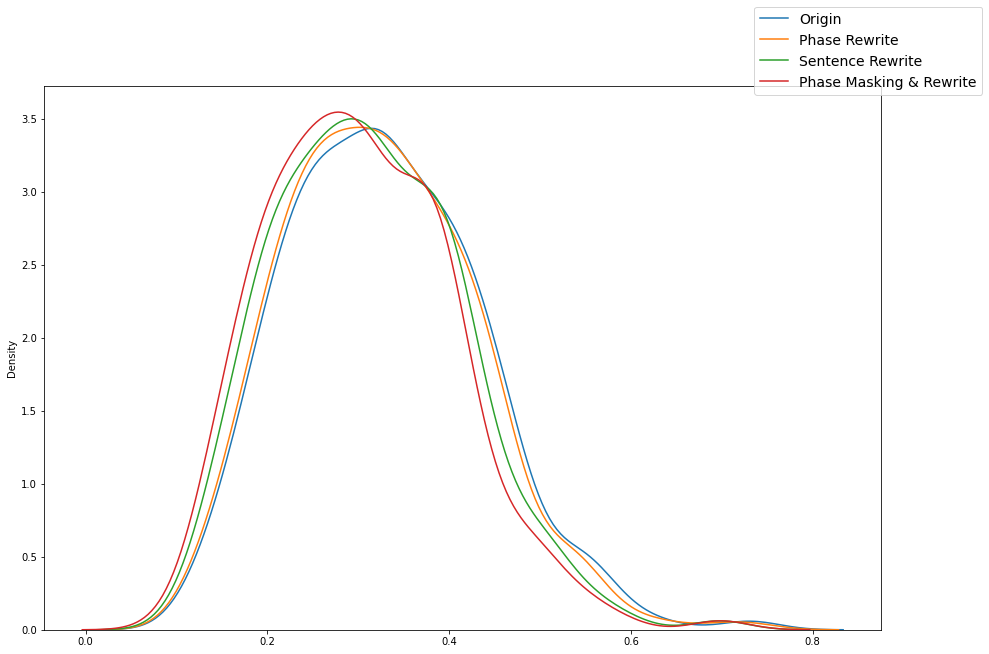

In [51]:
fig = plt.figure(figsize=(15,10))

sns.distplot(origin_ref_rouges, rug=False, hist=False)
sns.distplot(ph_re_ref_rouges, rug=False, hist=False)
sns.distplot(se_re_ref_rouges, rug=False, hist=False)
sns.distplot(ph_mr_ref_rouges, rug=False, hist=False)
fig.legend(labels=['Origin','Phase Rewrite', 'Sentence Rewrite', 'Phase Masking & Rewrite'], fontsize=14)
plt.show()

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

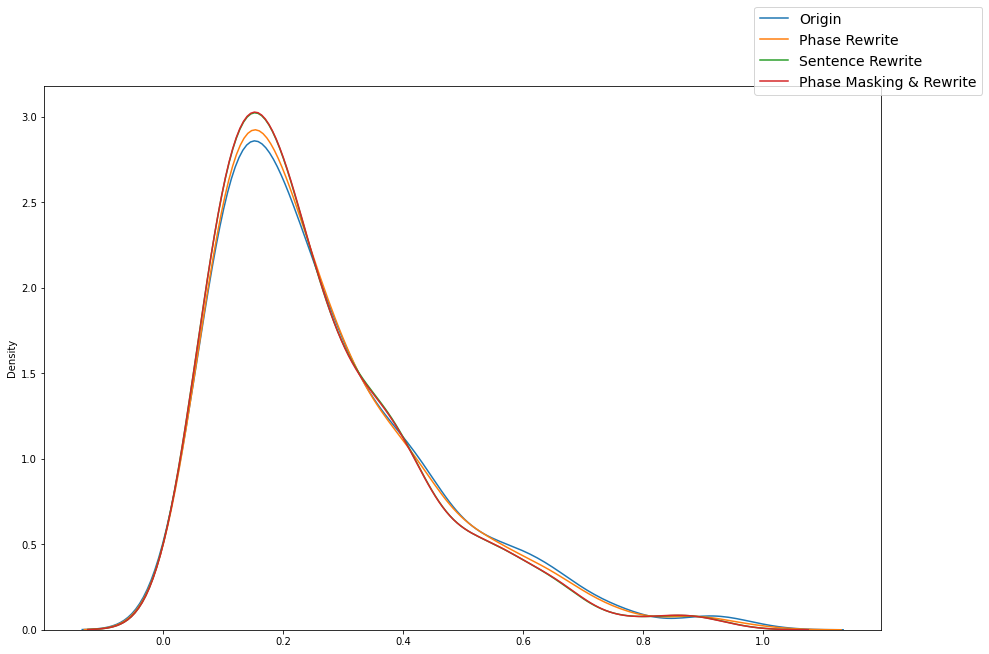

In [52]:
fig = plt.figure(figsize=(15,10))

sns.distplot(origin_doc_sims, rug=False, hist=False)
sns.distplot(ph_re_doc_sims, rug=False, hist=False)
sns.distplot(se_re_doc_sims, rug=False, hist=False)
sns.distplot(ph_mr_doc_sims, rug=False, hist=False)
fig.legend(labels=['Origin','Phase Rewrite', 'Sentence Rewrite', 'Phase Masking & Rewrite'], fontsize=14)
plt.show()

Rewrite Phase

In [17]:
print("Mean cosine similarity between document and summaries : {}".format(round(np.mean(ph_re_doc_sims), 4)))
print("Mean ROUGE score between reference and summaries : {}".format(round(np.mean(ph_re_ref_rouges), 4)))

Mean cosine similarity between document and summaries : 0.2648
Mean ROUGE score between reference and summaries : 0.3242


Rewrite Sentence

In [19]:
print("Mean cosine similarity between document and summaries : {}".format(round(np.mean(se_re_doc_sims), 4)))
print("Mean ROUGE score between reference and summaries : {}".format(round(np.mean(se_re_ref_rouges), 4)))

Mean cosine similarity between document and summaries : 0.257
Mean ROUGE score between reference and summaries : 0.3119


Phase masking and Rewriting

In [20]:
print("Mean cosine similarity between document and summaries : {}".format(round(np.mean(ph_mr_doc_sims), 4)))
print("Mean ROUGE score between reference and summaries : {}".format(round(np.mean(ph_mr_ref_rouges), 4)))

Mean cosine similarity between document and summaries : 0.257
Mean ROUGE score between reference and summaries : 0.3018
